<a href="https://colab.research.google.com/github/DJCordhose/ml-resources/blob/main/notebooks/priors/extrapolate_lattice_beer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lattice based models for extrapolating regression

### Lattice based models

* allow you to actively encode domain knowledge into the learning process
* specify constraints such as monotonicity
* constraints are specified as lattices overlaying the learning process
* lattices are a way to specify constraints
* additional regularization can be added to the lattices
* domain knowledge to better extrapolate to the parts of the input space not covered by the training dataset
* avoid unexpected model behavior when the serving distribution is different from the training distribution

### Links
* https://www.tensorflow.org/lattice
* https://blog.tensorflow.org/2020/02/tensorflow-lattice-flexible-controlled-and-interpretable-ML.html
* https://www.tensorflow.org/lattice/tutorials/premade_models
* https://github.com/tensorflow/lattice
* https://jmlr.org/papers/v17/15-243.html

# Installation

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

2022-06-14 14:33:10.710210: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-14 14:33:10.713952: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-14 14:33:10.713961: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


'2.9.1'

In [ ]:
tf.random.set_seed(42)

In [ ]:
import numpy as np
np.random.seed(42)

np.__version__

'1.22.4'

In [ ]:
# notebook does not need GPU, but we could turn it on any time
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [ ]:
# https://www.tensorflow.org/lattice/install

!pip install -q --upgrade tensorflow-lattice

In [ ]:
import tensorflow_lattice as tfl

In [ ]:
import numpy as np
np.__version__

'1.22.4'

In [ ]:
# https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/RSquare
!pip install -q tensorflow-addons

In [ ]:
import tensorflow_addons as tfa
tfa.__version__

'0.17.1'

In [ ]:
# https://github.com/AndreasMadsen/python-lrcurve
!pip install -q lrcurve

In [ ]:
from lrcurve import KerasLearningCurve

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

figsize_3d = (20, 10)

# Sample Application: Predicting beer consumption

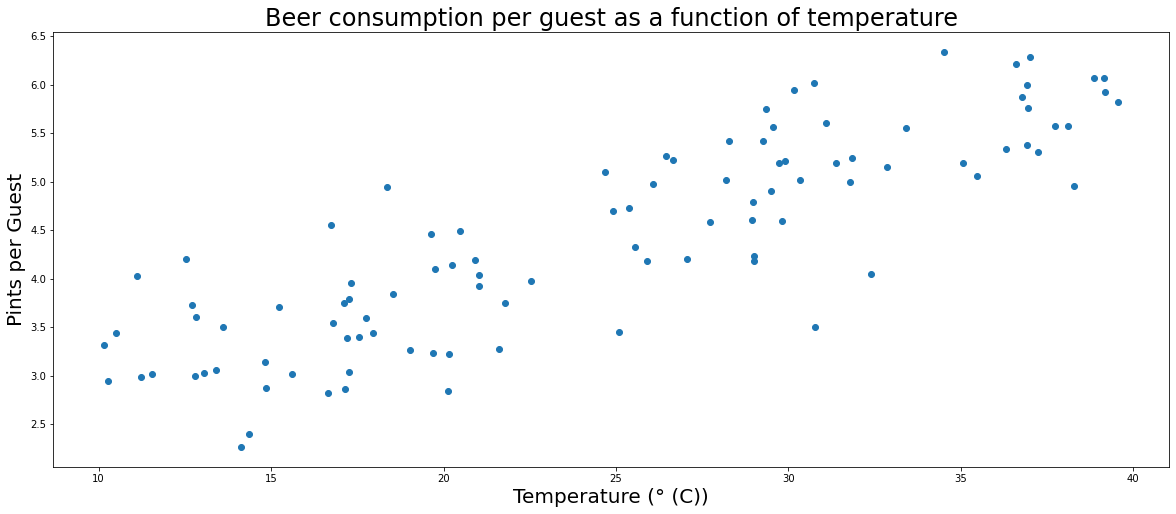

In [ ]:
n = 100
m = .1
b = 2

noise_level = .6
noise = np.random.normal(0, noise_level, n)

title = 'Beer consumption per guest as a function of temperature'
x_label = 'Temperature (° (C))'
y_label = 'Pints per Guest'

# sort is not necessary, but makes x easier to understand
# x = np.sort(np.random.uniform(1, 4, n))
x = np.sort(np.random.uniform(10, 40, n))

y = m*x+b + noise

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)

plt.scatter(x, y);

# Extrapolation using classic NNs

In [ ]:
from tensorflow.keras.layers import Dense, Input
 
model = tf.keras.Sequential([
  Input(shape=1),
  # uncomment to have this non-linear
  # Dense(units=500, activation='relu'),                   
  # Dense(units=500, activation='relu'),                   
  # Dense(units=500, activation='relu'),                   
  Dense(units=1)                   
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


2022-06-14 14:33:16.674665: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-14 14:33:16.674744: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-14 14:33:16.674773: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-BEN73DP): /proc/driver/nvidia/version does not exist
2022-06-14 14:33:16.676479: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
model.compile(loss='mse',
             optimizer='adam',
             metrics=[tfa.metrics.RSquare()])

In [ ]:
%%time

EPOCHS = 1000
BATCH_SIZE = 10

history = model.fit(x, y,
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 18.2 s, sys: 5.19 s, total: 23.4 s
Wall time: 13.7 s


In [ ]:
model.evaluate(x, y)

4/4 [==============================] - 0s 2ms/step - loss: 0.2957 - r_square: 0.7270


[0.2956945300102234, 0.7270236015319824]

4/4 [==============================] - 0s 2ms/step


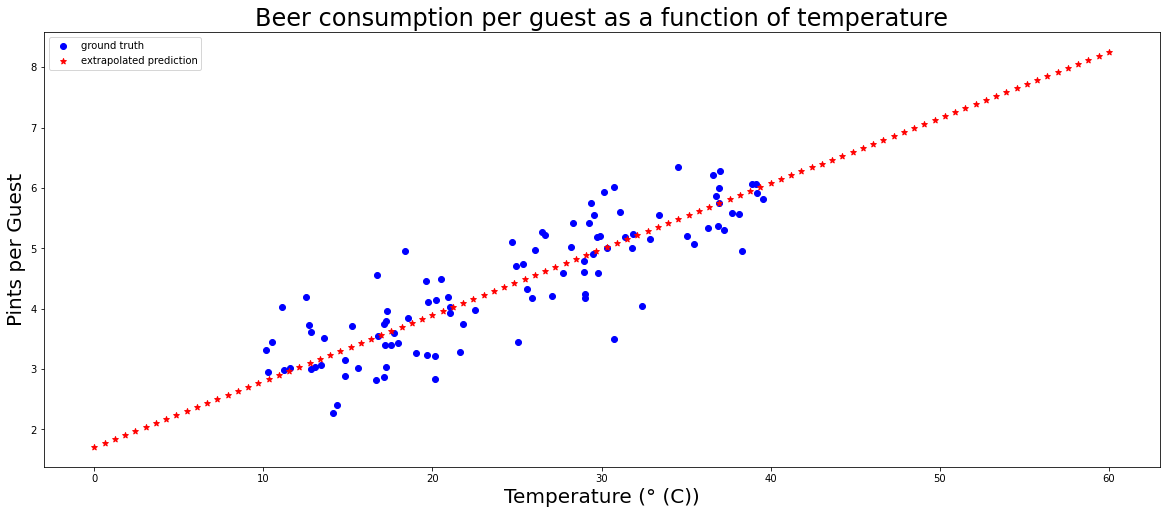

In [ ]:
x_extrapolated = np.linspace(0.0, 60.0, num=100)
y_pred = model.predict(x_extrapolated)

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)

plt.scatter(x, y, c='b');
plt.scatter(x_extrapolated, y_pred, c='r', marker='*');
plt.legend(['ground truth', 'extrapolated prediction']);

# Calibrated Linear Model

https://www.tensorflow.org/lattice/tutorials/premade_models

In [ ]:
MAX_BEERS = 10.0

In [ ]:
# https://www.tensorflow.org/lattice/api_docs/python/tfl/configs/FeatureConfig

temp_feature = tfl.configs.FeatureConfig(
        name='temperature',
        pwl_calibration_num_keypoints=10,

        # THIS IS THE CORE OF HOW WE BRING IN OUR WORLD KNOWLEDGE
        # the hotter the more beer        
        monotonicity='increasing',
        # diminishing returns on temperature
        pwl_calibration_convexity='concave',
    
        # bad idea, but we can try that out
        # monotonicity='decreasing',
#         pwl_calibration_convexity='convex',

        regularizer_configs=[
            # https://www.tensorflow.org/lattice/overview#controlled_flexibility_with_regularizers
            # smoothing, impact is subtle
            tfl.configs.RegularizerConfig(name='calib_wrinkle', l2=0.1),
        ],
    )

In [ ]:
feature_configs = [temp_feature]

In [ ]:
features = {
    "temperature": x
}

In [ ]:
feature_keypoints = tfl.premade_lib.compute_feature_keypoints(
    feature_configs=feature_configs, features=features)
tfl.premade_lib.set_feature_keypoints(
    feature_configs=feature_configs,
    feature_keypoints=feature_keypoints,
    add_missing_feature_configs=False)

In [ ]:
# tfl.configs.CalibratedLinearConfig?

In [ ]:
# https://www.tensorflow.org/lattice/api_docs/python/tfl/configs/CalibratedLinearConfig

linear_model_config = tfl.configs.CalibratedLinearConfig(
    feature_configs=feature_configs,
    output_calibration=True,
    output_initialization=np.linspace(0.0, MAX_BEERS, num=10),
    regularizer_configs=[
        # https://www.tensorflow.org/lattice/overview#common-sense_shape_constraints
        # hessian would make graph more linear, impact is subtle
        tfl.configs.RegularizerConfig(name='output_calib_hessian', l2=1e-4),
    ])
# A CalibratedLinear premade model constructed from the given model config.
linear_model = tfl.premade.CalibratedLinear(linear_model_config)
linear_model.summary()

Model: "calibrated_linear"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tfl_input_temperature (Inpu  [(None, 1)]              0         
 tLayer)                                                         
                                                                 
 tfl_calib_temperature (PWLC  (None, 1)                10        
 alibration)                                                     
                                                                 
 tf.identity (TFOpLambda)    (None, 1)                 0         
                                                                 
 concatenate (Concatenate)   (None, 1)                 0         
                                                                 
 tfl_linear_0 (Linear)       (None, 1)                 1         
                                                                 
 tfl_output_calib (PWLCalibr  (None, 1)          

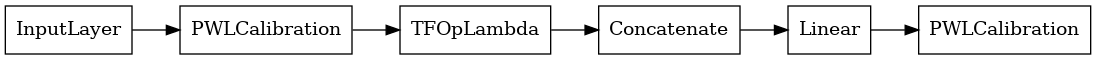

In [ ]:
# Let's plot our model.
tf.keras.utils.plot_model(linear_model, 
                          show_layer_names=False, 
                          # show_shapes=True, 
                          rankdir='LR')

## Fitted model

In [ ]:
linear_model.compile(loss='mse',
             optimizer='adam',
             metrics=[tfa.metrics.RSquare()])

In [ ]:
%%time

EPOCHS = 100
BATCH_SIZE = 10

history = linear_model.fit(x, y,
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 4.38 s, sys: 921 ms, total: 5.3 s
Wall time: 3.99 s


In [ ]:
linear_model.evaluate(x, y)

4/4 [==============================] - 0s 2ms/step - loss: 0.3196 - r_square: 0.7060


[0.31960421800613403, 0.7059803009033203]

## Calibrated Feature

In [ ]:
linear_model.layers

In [ ]:
input_layer = linear_model.layers[0]
calibration_layer = linear_model.layers[1]

calibration_model = tf.keras.Sequential([
            input_layer,
            calibration_layer
])

In [ ]:
# slope of linear pieces for all keypoints
calibration_layer.weights

[<tf.Variable 'tfl_calib_temperature/pwl_calibration_kernel:0' shape=(10, 1) dtype=float32, numpy=
 array([[0.20215943],
        [0.09682032],
        [0.04202325],
        [0.02160287],
        [0.02914947],
        [0.057196  ],
        [0.03206079],
        [0.02383489],
        [0.05341456],
        [0.01868928]], dtype=float32)>]

4/4 [==============================] - 0s 2ms/step


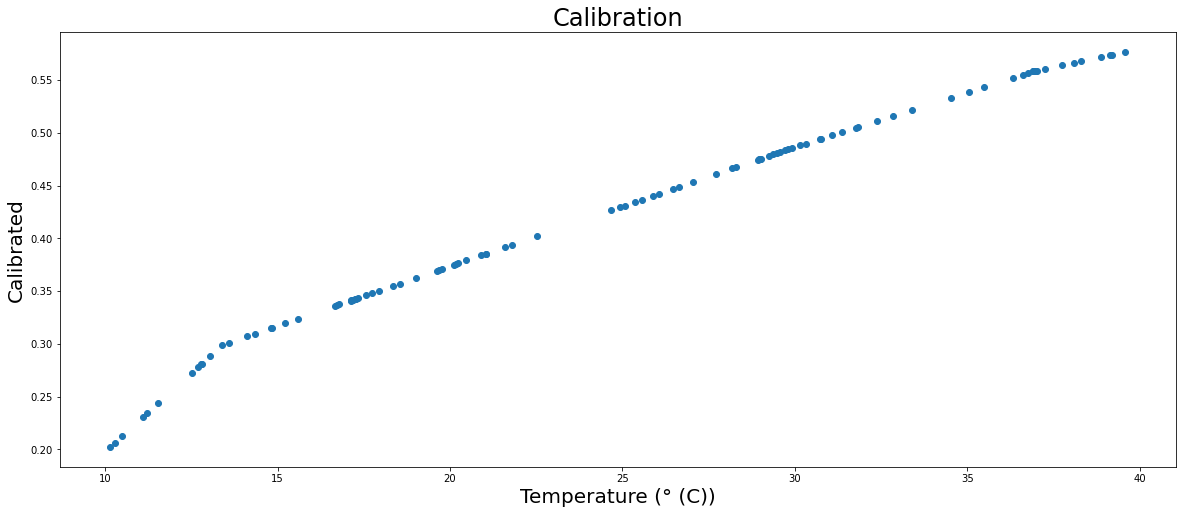

In [ ]:
x_calibrated = calibration_model.predict(x)

plt.xlabel(x_label)
plt.ylabel('Calibrated')
plt.title('Calibration')

plt.scatter(x, x_calibrated);

## Prediction

4/4 [==============================] - 0s 1ms/step


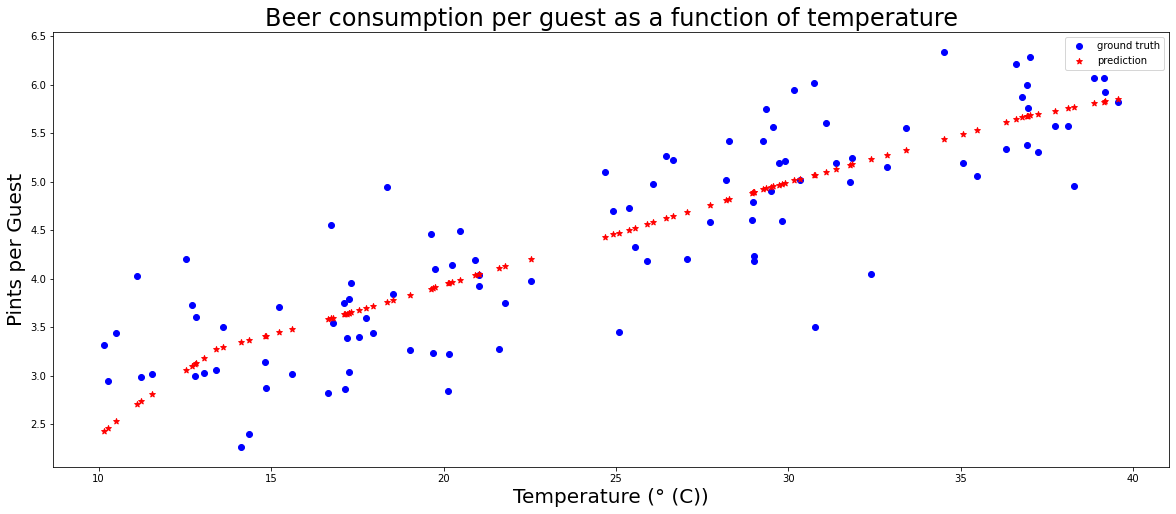

In [ ]:
y_pred = linear_model.predict(x)

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)

plt.scatter(x, y, c='b');
plt.scatter(x, y_pred, c='r', marker='*');
plt.legend(['ground truth', 'prediction']);

## Extrapolation

In [ ]:
x_extrapolated = np.linspace(0.0, 60.0, num=100)

4/4 [==============================] - 0s 2ms/step


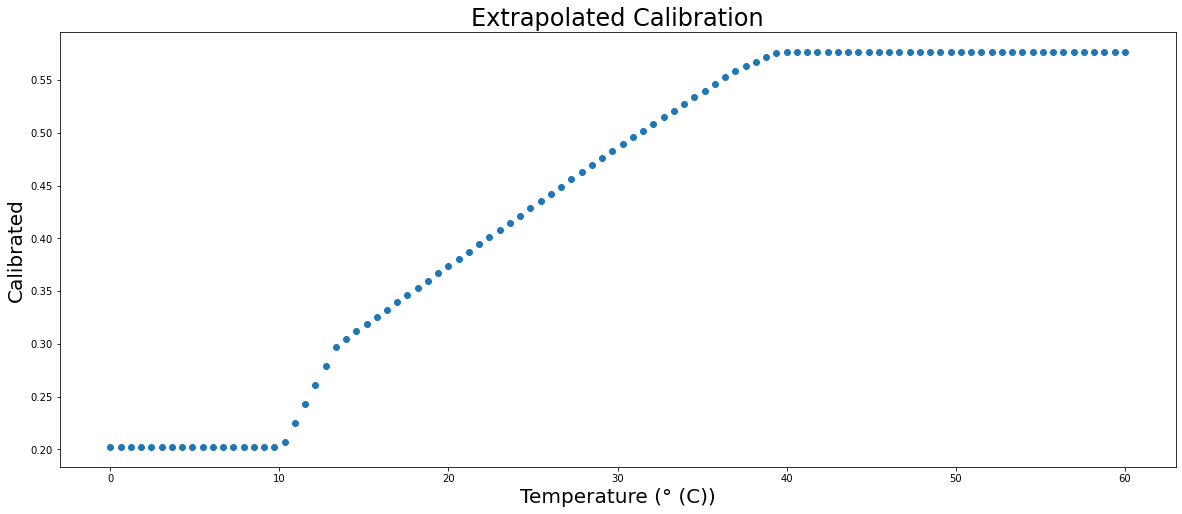

In [ ]:
x_calibrated = calibration_model.predict(x_extrapolated)

plt.xlabel(x_label)
plt.ylabel('Calibrated')
plt.title('Extrapolated Calibration')

plt.scatter(x_extrapolated, x_calibrated);

In [ ]:
y_pred = linear_model.predict(x_extrapolated)
y_pred.max()

4/4 [==============================] - 0s 2ms/step


5.851699

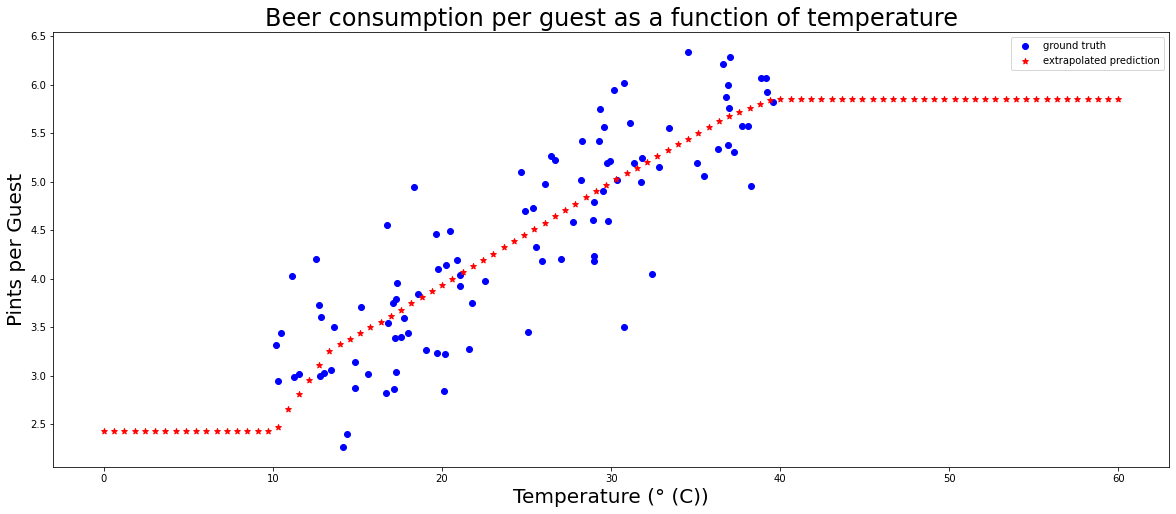

In [ ]:
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title(title)

plt.scatter(x, y, c='b');
plt.scatter(x_extrapolated, y_pred, c='r', marker='*');
plt.legend(['ground truth', 'extrapolated prediction']);

# From Calibration to Lattice

* this is just one feature
* calibration pretty much determines final prediction
* if we want to use two features, how would we combine calibrated features?

<img src='https://2.bp.blogspot.com/-1TTFfEsTZGM/Xj3EDMnP0nI/AAAAAAAACqU/MzUmff-fll4EMxj6JphYD-KJn8eaHdXngCLcBGAsYHQ/s1600/laticefunction.png'>

_A lattice is an interpolated look-up table that can approximate arbitrary input-output relationships in your data._

https://blog.tensorflow.org/2020/02/tensorflow-lattice-flexible-controlled-and-interpretable-ML.html

## Data in 2d

In [ ]:
n = 100

noise_level = .6
noise = np.random.normal(0, noise_level, n)

title = 'Beer consumption per guest'
x1_label = 'Temperature (° (C))'
x2_label = 'Weight of Guest (kg)'
y_label = 'Pints per Guest'

# sort is not necessary, but makes x easier to understand
x1 = np.sort(np.random.uniform(10, 40, n))
l1 = 0.6
m1 = .1
b1 = 2
x2 = np.sort(np.random.uniform(40, 120, n))
l2 = 1 - l1
m2 = .07
b2 = 0

y = l1 * (m1*x1+b1) + l2 * (m2*x2+b2) + noise

In [ ]:
y.max()

7.732428456792367

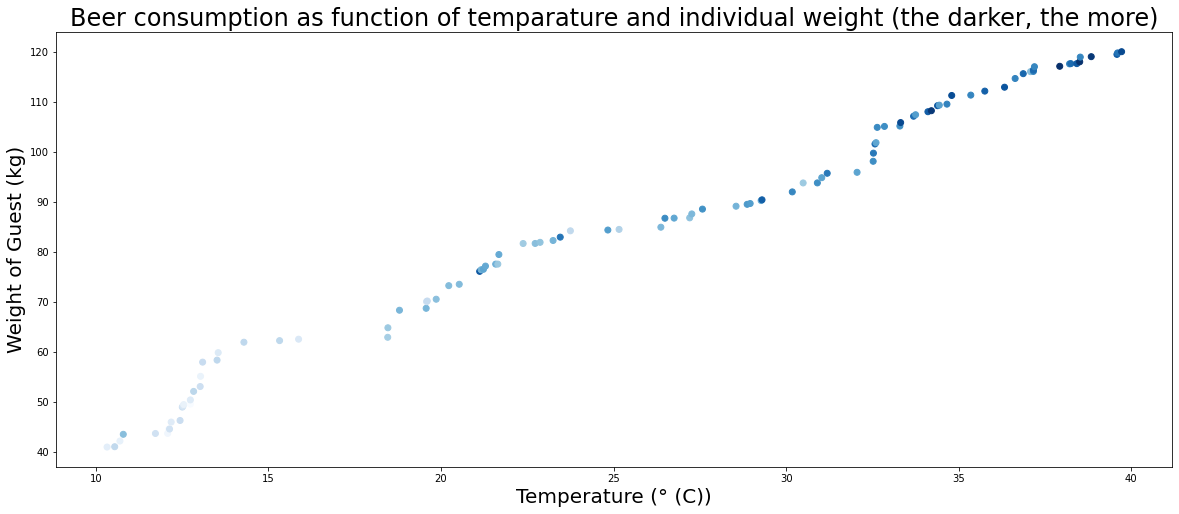

In [ ]:
plt.title('Beer consumption as function of temparature and individual weight (the darker, the more)')
plt.xlabel(x1_label)
plt.ylabel(x2_label)
plt.scatter(x1, x2, c=y, cmap = 'Blues');

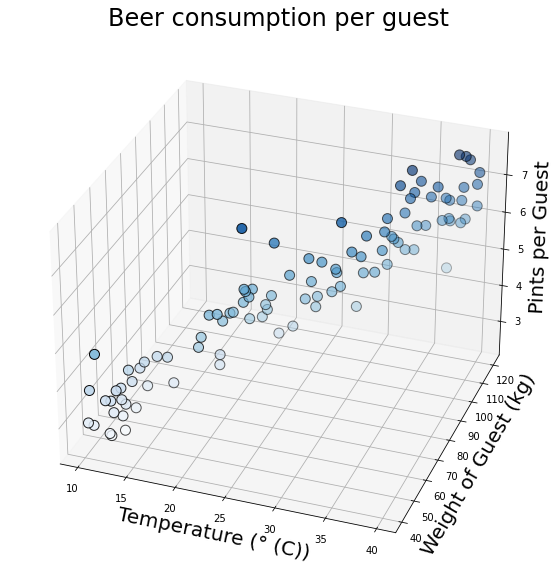

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=figsize_3d)

ax = fig.add_subplot(111, projection='3d')
ax.set_title(title)
ax.set_xlabel(x1_label)
ax.set_ylabel(x2_label)
ax.set_zlabel(y_label)

# we can have the probability encoded in shade of color
ax.scatter(x1, x2, y, 
           c=y, 
           # https://matplotlib.org/3.5.0/tutorials/colors/colormaps.html
          #  cmap=plt.cm.RdBu,
          #  cmap = 'gist_yarg',
           cmap = 'Blues',
          #  marker='o', 
           edgecolors='k',
          #  depthshade=True,
           s=100)

# https://en.wikipedia.org/wiki/Azimuth
ax.view_init(azim=-70)
# ax.view_init(elev=5, azim=-45)

## Lattice model

In [ ]:
weight_feature = tfl.configs.FeatureConfig(
        name='weight',
        # THIS IS THE CORE OF HOW WE BRING IN OUR WORLD KNOWLEDGE
        monotonicity='increasing',
        # we could add more information like
        # reflects_trust_in: one another feature, https://www.tensorflow.org/lattice/api_docs/python/tfl/configs/TrustConfig
        # dominates: value of another feature: https://www.tensorflow.org/lattice/api_docs/python/tfl/configs/DominanceConfig 
        pwl_calibration_num_keypoints=10,
    )

In [ ]:
feature_configs = [temp_feature, weight_feature]

In [ ]:
features = {
    "temperature": x1,
    "weight": x2
}

In [ ]:
feature_keypoints = tfl.premade_lib.compute_feature_keypoints(
    feature_configs=feature_configs, features=features)
tfl.premade_lib.set_feature_keypoints(
    feature_configs=feature_configs,
    feature_keypoints=feature_keypoints,
    add_missing_feature_configs=False)

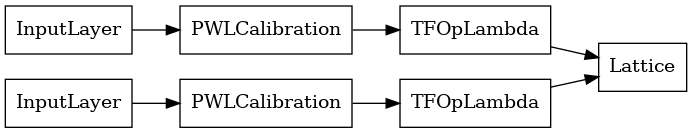

In [ ]:
# https://www.tensorflow.org/lattice/api_docs/python/tfl/configs/CalibratedLatticeConfig

# This is a calibrated lattice model: inputs are calibrated, then combined
# non-linearly using a lattice layer.
lattice_model_config = tfl.configs.CalibratedLatticeConfig(
    feature_configs=feature_configs,
    # We initialize the output to [-2.0, 2.0] since we'll be using logits.
    # output_initialization=[-2.0, 2.0],
    output_initialization=np.linspace(0.0, MAX_BEERS, num=10),

    regularizer_configs=[
        # Torsion regularizer applied to the lattice to make it more linear.
        tfl.configs.RegularizerConfig(name='torsion', l2=1e-2),
        # Globally defined calibration regularizer is applied to all features.
        tfl.configs.RegularizerConfig(name='calib_hessian', l2=1e-2),
    ])
# A CalibratedLattice premade model constructed from the given model config.
lattice_model = tfl.premade.CalibratedLattice(lattice_model_config)
# Let's plot our model.
tf.keras.utils.plot_model(lattice_model, show_layer_names=False, rankdir='LR')

In [ ]:
lattice_model.summary()

Model: "calibrated_lattice"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 tfl_input_temperature (InputLa  [(None, 1)]         0           []                               
 yer)                                                                                             
                                                                                                  
 tfl_input_weight (InputLayer)  [(None, 1)]          0           []                               
                                                                                                  
 tfl_calib_temperature (PWLCali  (None, 1)           10          ['tfl_input_temperature[0][0]']  
 bration)                                                                                         
                                                                                 

In [ ]:
lattice_model.compile(loss='mse',
             optimizer='adam',
             metrics=[tfa.metrics.RSquare()])

In [ ]:
X = {
    "tfl_input_temperature": x1,
    "tfl_input_weight": x2
}

In [ ]:
%%time

EPOCHS = 100
BATCH_SIZE = 10

history = lattice_model.fit(X, y,
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 5.38 s, sys: 828 ms, total: 6.21 s
Wall time: 4.2 s


In [ ]:
lattice_model.evaluate(X, y)

4/4 [==============================] - 0s 2ms/step - loss: 0.4430 - r_square: 0.7569


[0.44301143288612366, 0.7568524479866028]

## Calibrated features

In [ ]:
lattice_model.layers

4/4 [==============================] - 0s 1ms/step


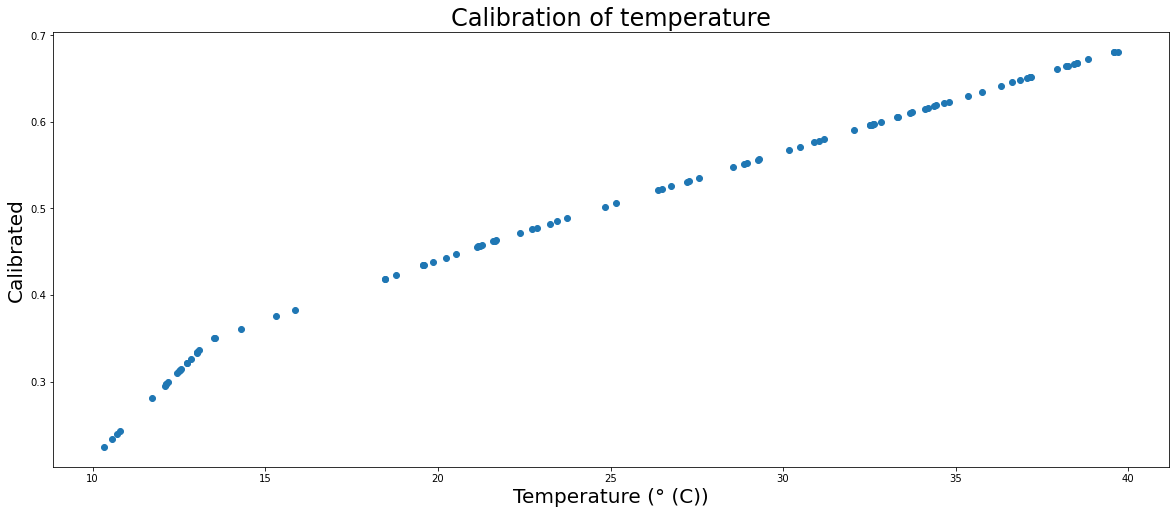

In [ ]:
temperature_input_layer = lattice_model.layers[0]
temperature_calibration_layer = lattice_model.layers[2]

temperature_calibration_model = tf.keras.Sequential([
            temperature_input_layer,
            temperature_calibration_layer
])

x_calibrated = temperature_calibration_model.predict(x1)

plt.xlabel(x_label)
plt.ylabel('Calibrated')
plt.title('Calibration of temperature')

plt.scatter(x1, x_calibrated);

4/4 [==============================] - 0s 1ms/step


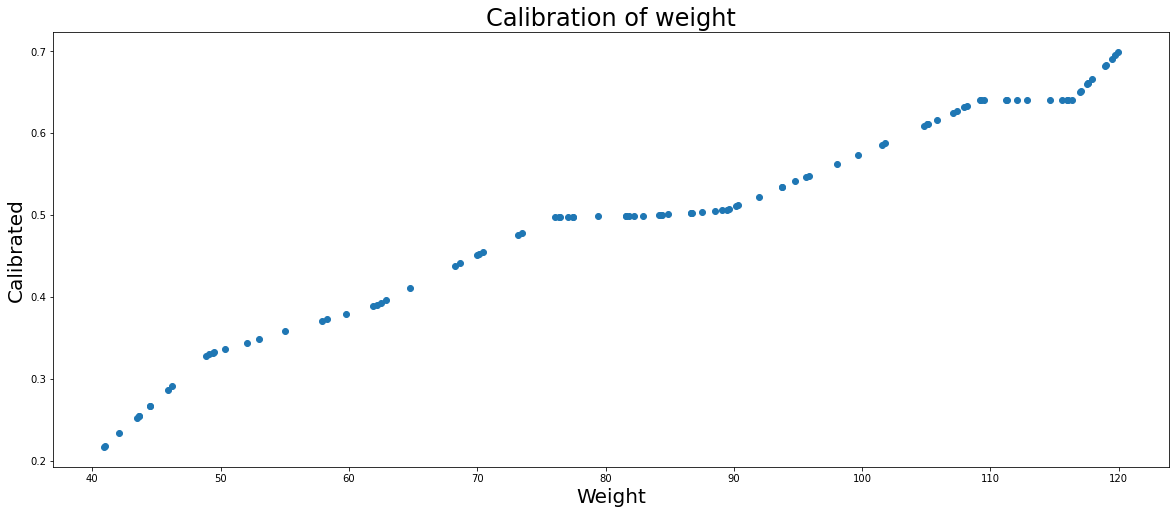

In [ ]:
weight_input_layer = lattice_model.layers[1]
weight_calibration_layer = lattice_model.layers[3]

weight_calibration_model = tf.keras.Sequential([
            weight_input_layer,
            weight_calibration_layer
])

x_calibrated = weight_calibration_model.predict(x2)

plt.xlabel('Weight')
plt.ylabel('Calibrated')
plt.title('Calibration of weight')

plt.scatter(x2, x_calibrated);

## Prediction

In [ ]:
y_pred = lattice_model.predict(X)
y_pred.max()

4/4 [==============================] - 0s 1ms/step


6.962522

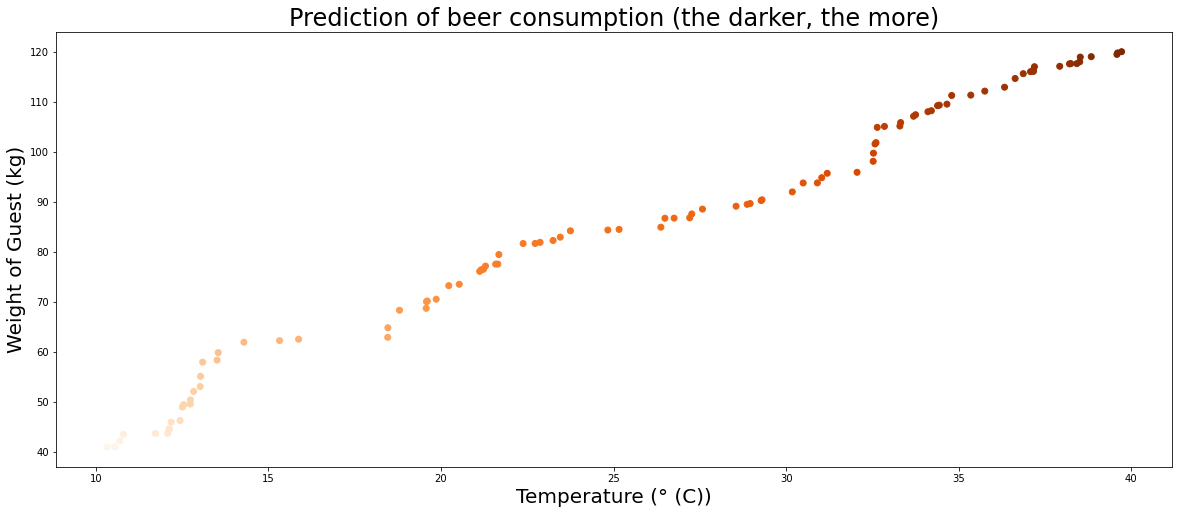

In [ ]:
plt.title('Prediction of beer consumption (the darker, the more)')

plt.xlabel(x1_label)
plt.ylabel(x2_label)

# this is a complete overlap, so there is no reason in plotting both
plt.scatter(x1, x2, c=y_pred, cmap = 'Oranges');

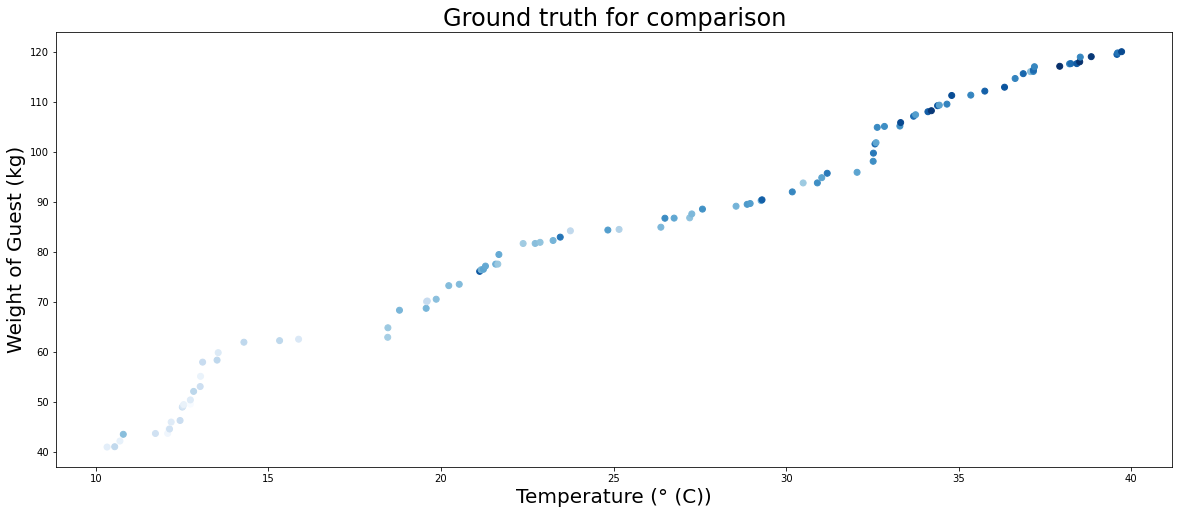

In [ ]:
plt.title('Ground truth for comparison')

plt.xlabel(x1_label)
plt.ylabel(x2_label)

plt.scatter(x1, x2, c=y, cmap = 'Blues');

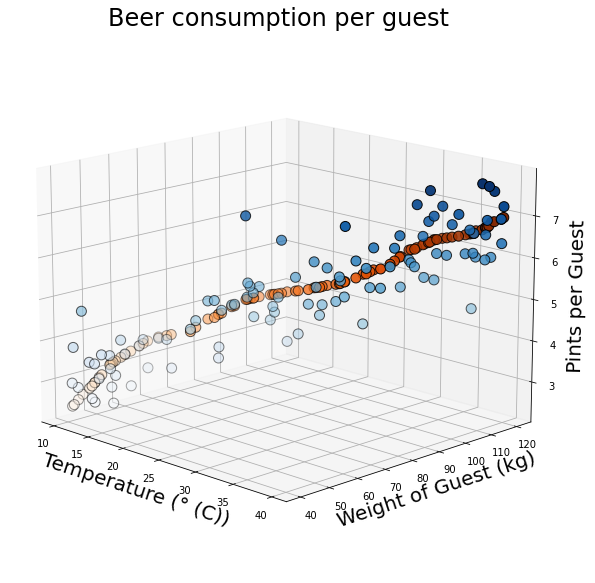

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=figsize_3d)

ax = fig.add_subplot(111, projection='3d')
ax.set_title(title)
ax.set_xlabel(x1_label)
ax.set_ylabel(x2_label)
ax.set_zlabel(y_label)

ax.scatter(x1, x2, y, 
           c=y, 
           cmap = 'Blues',
           edgecolors='k',
           s=100)

ax.scatter(x1, x2, y_pred, 
           c=y_pred, 
           cmap = 'Oranges',
           edgecolors='k',
           s=100)

# https://en.wikipedia.org/wiki/Azimuth
ax.view_init(azim=-45, elev=15)

## Extrapolation (makes clear what the lattice outputs)

In [ ]:
# 4 poles of the lattice
lattice_layer = lattice_model.layers[6]
lattice_layer.weights

[<tf.Variable 'tfl_lattice_0/lattice_kernel:0' shape=(4, 1) dtype=float32, numpy=
 array([[0.25588444],
        [5.1290913 ],
        [5.1606016 ],
        [9.945335  ]], dtype=float32)>]

In [ ]:
# better for 2d plot, but a bit too crowded for 3d
N = 5000
# N = 1000

X_extrapolated = np.random.random((N ,N))
X_extrapolated[0] *= 60
X_extrapolated[1] *= 170
X_extrapolated[1] += 30

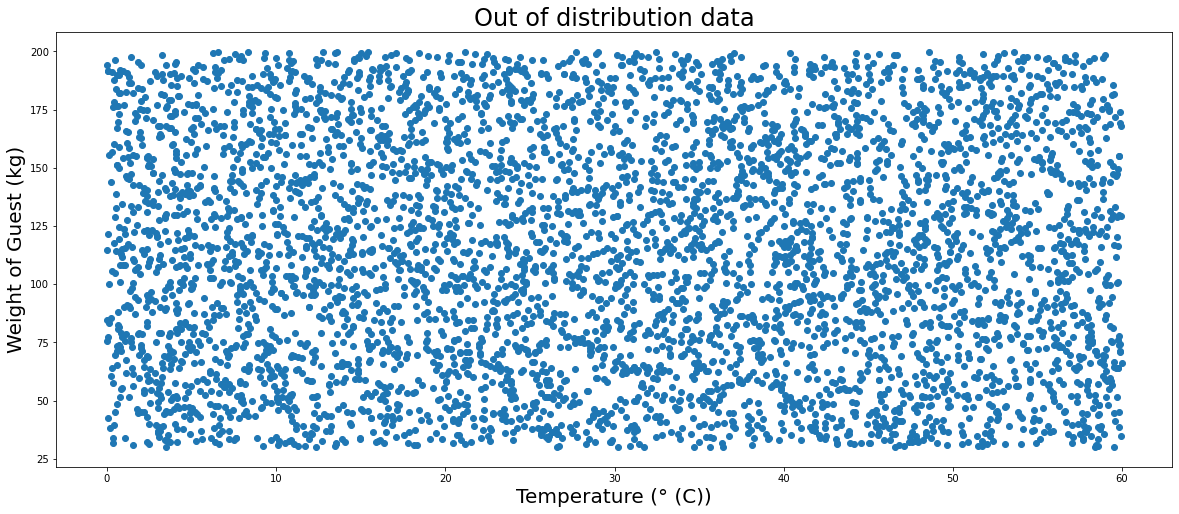

In [ ]:
plt.title('Out of distribution data')

plt.xlabel(x1_label)
plt.ylabel(x2_label)

plt.scatter(X_extrapolated[0], X_extrapolated[1]);

In [ ]:
X_extrapolated_features = {
    "tfl_input_temperature": X_extrapolated[0],
    "tfl_input_weight": X_extrapolated[1]
}
y_pred_extrapolated = lattice_model.predict(X_extrapolated_features)
y_pred_extrapolated.max()

157/157 [==============================] - 0s 913us/step


6.962522

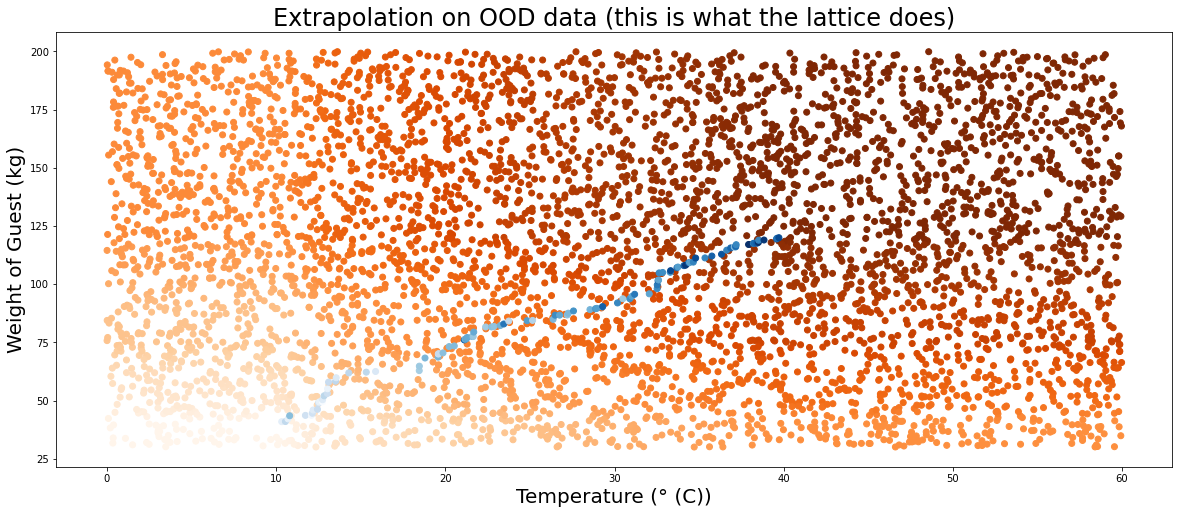

In [ ]:
plt.title('Extrapolation on OOD data (this is what the lattice does)')

plt.xlabel(x1_label)
plt.ylabel(x2_label)

plt.scatter(X_extrapolated[0], X_extrapolated[1], c=y_pred_extrapolated, cmap = 'Oranges');
plt.scatter(x1, x2, c=y, cmap = 'Blues');

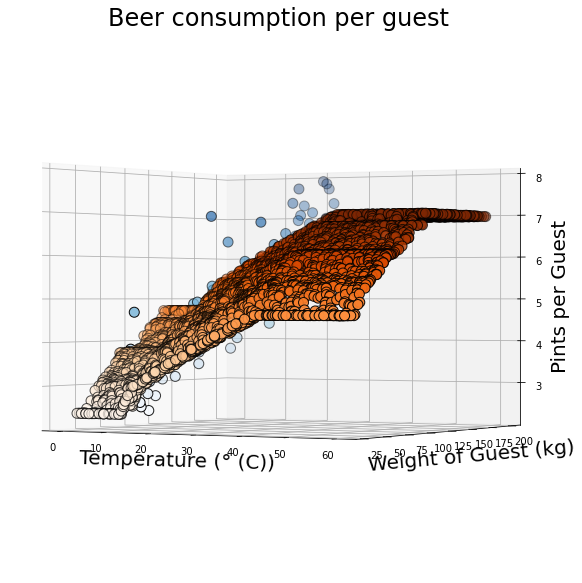

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=figsize_3d)

ax = fig.add_subplot(111, projection='3d')
ax.set_title(title)
ax.set_xlabel(x1_label)
ax.set_ylabel(x2_label)
ax.set_zlabel(y_label)

ax.scatter(X_extrapolated[0], X_extrapolated[1], y_pred_extrapolated, 
           c=y_pred_extrapolated, 
           cmap = 'Oranges',
           edgecolors='k',
           s=100)

ax.scatter(x1, x2, y, 
           c=y, 
           cmap = 'Blues',
           edgecolors='k',
           s=100)

# ax.view_init(azim=-45, elev=50)
ax.view_init(elev=0)

# Lattice Models are just TensorFlow graphs (with all the benefits included)

In [ ]:
linear_model.save('linear_model', save_format='tf')

INFO:tensorflow:Assets written to: linear_model/assets


In [ ]:
lattice_model.save('lattice_model', save_format='tf')

INFO:tensorflow:Assets written to: lattice_model/assets


In [ ]:
!ls -l linear_model

total 228
drwxr-xr-x 2 olli olli   4096 Jun 14 09:35 assets
-rw-r--r-- 1 olli olli  17777 Jun 14 14:33 keras_metadata.pb
-rw-r--r-- 1 olli olli 200719 Jun 14 14:33 saved_model.pb
drwxr-xr-x 2 olli olli   4096 Jun 14 14:33 variables


In [ ]:
!ls -l lattice_model

total 340
drwxr-xr-x 2 olli olli   4096 Jun 14 09:35 assets
-rw-r--r-- 1 olli olli  23407 Jun 14 14:33 keras_metadata.pb
-rw-r--r-- 1 olli olli 315235 Jun 14 14:33 saved_model.pb
drwxr-xr-x 2 olli olli   4096 Jun 14 14:33 variables
